### ------------------ Module 1: MeanRevertVectorBacktester ------------------

- What: Mean revertion algo
- Who : Code from Kevin.
- When: 16 August 2022 
- A few additions to compute sharpe and maxdd

$\color{red}{\text{Define Parameters:}}$

In [128]:
# Path to previously collected data
path = '../Modules/Data/'
type = 'feather'
symbol = 'BTCUSDT_1MINUTE_2Y'

print('* Path to data:', path)
print('* File type   :', type)
print('* File name   :', symbol)

* Path to data: ../Modules/Data/
* File type   : feather
* File name   : BTCUSDT_1MINUTE_2Y


#### 1. Load some key libaries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import  date,datetime

# Little function to keep track of code execution.
def Keep_Track():
    print("Executed successfully. " + datetime.now().strftime("%a %d %b @ %H:%M:%S") + "\n")
    
Keep_Track()

Executed successfully. Tue 16 Aug @ 09:14:51



#### 2. Define the class

In [2]:
class SingleVectorBT():
    '''
    Class for basic meanrevert strategy in vectorized backtesting
     Attributes
        ==========
        symbol: str
           financial instrument to work with
        start: str
            start date for data selection
        end: str
            end date for data selection
        tc: float
            proportional transaction costs (e.g. 0.5% = 0.005) per trade
        Methods
        =======
        get_data:
            retrieves and prepares the base data set
        run_strategy:
            runs the backtest for the momentum-based strategy
        plot_results:
            plots the performance of the strategy compared to the symbol
    '''

    def __init__(self,symbol,start,end,tc):
        self.symbol=symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
    
    def get_data(self,path,type):
        '''
        :param path: file path for import
        :param type: file type CSV or Feather
        :return:dataframe with cleaned data
        '''
        if type=='feather':
            df = pd.read_feather(os.path.join(path, f'{self.symbol}.{type}'))
            df = df.set_index('Open Time')
        elif type =='csv':
            df = pd.read_csv(os.path.join(path, f'{self.symbol}.{type}'))
            df = df.set_index('Open Time')
        else:
            print('type not supported')
        
        self.data = df.loc[self.start:self.end]
    
    def run_strategy(self):
        pass
    
    def plot_results(self):
        if self.results is None:
            print('No results to plot yet. Run a strategy')
        title='%s | TC = %.4f' % (self.symbol, self.tc)
        self.results[['cum_returns', 'cum_strategy']].plot(title=title,
                                                     figsize=(10, 6))
        plt.show()
    
    def calculate_perf(self):
        def calc_drawdown(cum_rets):
            # Calculate the running maximum
            running_max = np.maximum.accumulate(cum_rets.dropna())

            # Ensure the value never drops below 1
            running_max[running_max < 1] = 1

            # Calculate the percentage drawdown
            drawdown = (cum_rets) / running_max - 1
            return drawdown
        
        daily_return =self.results['strategy'].resample('D').agg(lambda x: (x + 1).prod() - 1)
        cum_return = (1+daily_return).cumprod()
        if np.std(daily_return) == 0:
            self.sharpe = 0
        else:
            self.sharpe = np.mean(daily_return) / np.std(daily_return) * (252 ** 0.5)
        drawdown = calc_drawdown(cum_return)
        self.max_dd = drawdown.min()

class SingleVectorBT_MR(SingleVectorBT):
    
    def run_strategy(self,lookback,threshold):
        '''
        :param lookback:lookback period for the strategy
        :param threshold:threshold for entry and exit
        :return: strategy return
        '''
        self.lookback=lookback
        self.threshold=threshold
        print(f'Running strategy: lookback = {lookback},threshold = {threshold},tc = {self.tc}')
        data=self.data.copy().dropna()
        data['Mean'] = data.Close.rolling(self.lookback).mean()
        data['Std'] = data.Close.rolling(self.lookback).std(ddof=0)
        data['Zscore'] = (data.Close - data.Mean) / data.Std
        data = data.dropna()
        data['return'] = data.Close.pct_change()

        # sell signals
        data['position'] = np.where(data['Zscore'] > self.threshold, -1, np.nan)
        
        # buy signals
        data['position'] = np.where(data['Zscore'] < -self.threshold, 1, data.position)

        # exit when revert to mean (close above / below mean => negative)
        data['position'] = np.where(data['Zscore'] * data['Zscore'].shift(1) < 0, 0, data.position)
        
        data['position'] = data.position.ffill().fillna(0)
        
        # calculate strategy daily return
        data['strategy'] = data['position'].shift(1) * data['return']

        # substract transaction cost
        trades = (data['position'].diff().fillna(0) != 0)
        data.loc[trades, 'strategy'] -= tc

        # calculate strategy returns
        data['cum_returns'] = (1 + data['return']).cumprod()
        data['cum_strategy'] = (1 + data['strategy']).cumprod()
        
        self.raw_return = data['cum_returns'].iloc[-1] - 1
        self.total_return = data['cum_strategy'].iloc[-1] - 1
        self.results=data
        self.calculate_perf()
        self.trade_summary()
        print(f'raw return:{self.raw_return},total return:{self.total_return},sharpe:{self.sharpe},max_dd:{self.max_dd}')
        return (self.total_return,self.sharpe,self.max_dd)
#         return 0
    


    def trade_summary(self):
        self.results.loc[self.results.position!=0,'sign']=1
        self.results['trades']=self.results.sign.shift(1)*self.results.strategy
        events = np.split(self.results.trades, np.where(np.isnan(self.results.trades.values))[0])
        events = [ev[~np.isnan(ev.values)] for ev in events if not isinstance(ev, np.ndarray)]
        # removing empty DataFrames
        events = [ev for ev in events if not ev.empty]
        d={}
        for e in events:
            if len(e)==1: #special case of 1 trade
                d[e.index[0]]=e[0]
            else:
                cum = (1+e).cumprod() #cum returns
                d[e.index[0]]=cum[-1]/cum[0]-1
        trades = pd.DataFrame.from_dict(d,orient='index')
        trades.columns=['trade_return']
        self.results.loc[trades.index,'trade_return']=trades.values
        self.results['trade_return_lag'] = self.results['trade_return'].shift(-1)
        self.results['Performance'] = self.results.sign * self.results.trade_return_lag.ffill()
        self.results['Performance'] = self.results['Performance'].shift(1)
        self.results['Performance'] = self.results.Performance.fillna(0)

    def plot_result(self):
        self.results=self.data.dropna()
        if self.results is None:
            print('No results to plot yet. Run a strategy')
        title='%s | FTC = %.4f,PTC = %.4f'% (self.symbol, self.ftc,self.ptc)
        plot = self.results[['cum_returns', 'cum_strategy']].plot(title=title,
                                                     figsize=(10, 6))
        return plot

print('* Class created.')  
print('')
Keep_Track()    

* Class created.

Executed successfully. Tue 16 Aug @ 09:14:57



#### 3. Usage

In [3]:
# Define start and end dates for the algo run.
start = '2020-08-01'
end = '2022-08-01'
# start = '2021-01-01'
# end = '2022-05-01'
# start = '2021-01-01'
# end = '2021-02-01'
lookback = 50
threshold = 2.5
tc=0

print('* Creating class')
mrbt = SingleVectorBT_MR(symbol,start,end,tc)

print('* Collecting data')
mrbt.get_data(path,type)

print('* Running strategy')
mrbt.run_strategy(lookback,threshold)

print('')
Keep_Track()

* Creating class
* Collecting data
* Running strategy
Running strategy: lookback = 50,threshold = 2.5,tc = 0
raw return:1.0642585628870536,total return:73.51998129800498,sharpe:3.7651350749728287,max_dd:-0.2650560559730234

Executed successfully. Tue 16 Aug @ 09:17:16



3.1 Take a look at the results or save the data

In [6]:
# mrbt.plot_results()
# mrbt.results.reset_index().to_feather('backtesting_vt_Bostock_2Y.feather')
# mrbt.results

#### 4. Further analysis

4.1 Define a few useful functions to assist in calculating drawdown etc

In [148]:
# Shift function - needed to pick up all return data for drawdown calculations.
# Example
# a = np.array([0,0,0,1,1,1,0,0,0,1,1,0,0])
# shift(a,1) adds an extra one to the end of each group
# [0,0,0,1,1,1,1,0,0,1,1,1,0]
def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = 0
        e[n:] = xs[:-n]
    return ((e==1) | (xs==1))*1

# This function allows us to cherry pick algo runs (say those predicted by a model as good)
# Using the example above we have 2 runs
# so define Blocks = [1,1] includes them all.  Blocks = [0,1] will only pick up the second one.
# Get_Algo_Runs(a, [0,1]) = [0,0,0,0,0,0,0,0,0,1,1,0,0]
# Note this adds an extra one using the shift function.
def Get_Algo_Runs(All_Runs, Blocks):

    Started = False
    Skipping = False
    Block_Counter = 0
    
    # Collect model results
    Model_Run = np.empty(0)
    print('*', len(All_Runs))
    for indx,i in enumerate(All_Runs):
        if indx%100000 == 0:
            print(indx)
        # The start of a trade and it is a trade we are keeping
        if i == 1 and Blocks[Block_Counter] == 1:
            Started = True

        # The start of a trade we are ignoring
        if i == 1 and Blocks[Block_Counter] == 0:
            Skipping = True

        # We are skipping and the trade has finished    
        if i == 0 and Skipping:
            Skipping = False
            Block_Counter = Block_Counter+1
        
        # We have started and the trade has ended.
        if i == 0 and Started:
            Started = False
            Block_Counter = Block_Counter+1     

        if Started:
            Model_Run = np.append(Model_Run,1)
        else:
            Model_Run = np.append(Model_Run,0)
        
    return shift(Model_Run,1)

Keep_Track()

Executed successfully. Wed 17 Aug @ 13:51:19



In [18]:
# Example
a = np.array([1,0,0,1,1,1,0,0,0,1,1,1,1,0,0])
Get_Algo_Runs(a, [1,0,1,0])

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0])

Function to calculate drawdown and sharpe ratio using selected runs

In [139]:
def calculate_perf(mid, end, Threshold):
    
    # Define the drawdown function.
    def calc_drawdown(cum_rets):
        # Calculate the running maximum
        running_max = np.maximum.accumulate(cum_rets.dropna())

        # Ensure the value never drops below 1
        running_max[running_max < 1] = 1

        # Calculate the percentage drawdown
        drawdown = (cum_rets) / running_max - 1
        return drawdown
    
    # Create a copy of the results for testing.
    Bostock_Temp = mrbt.results.copy()
    
    Bostock_Temp = Bostock_Temp.reset_index()
    
    # Keep only the data in the specified range.
    Bostock_Temp = Bostock_Temp[(Bostock_Temp['Open Time'] >= mid)  & (Bostock_Temp['Open Time'] < end)]
    
#     print(len(Bostock_Temp))
    
    Bostock_Temp = Bostock_Temp.set_index('Open Time')
    
    # Define an indicator (i.e. the block defintion to decide which trades to keep.)
    # The dropna keeps only the single trade return result for each run.
    Indicator = ((Bostock_Temp['trade_return'].dropna() > Threshold)*1).values
    
#     Indicator = Ind
    
#     print(len(Indicator))

    # The earliest date in the split that starts a position.
    # The idea is to capture where we have created a split in the data mid trade.
    Earliest_Date = np.min((Bostock_Temp['trade_return_lag'].reset_index().dropna())['Open Time'])

    # Set all positions prior to this to first date to zero 
    Bostock_Temp.loc['2001-06-01':Earliest_Date,  'position'] = 0 
    Bostock_Temp.loc['2001-06-01':Earliest_Date,  'strategy'] = 0

    # Extract all possible runs
    # So this looks like [0,0,0,0,1,1,1,1,0,0,0, etc]
    All_Runs = ((~(Bostock_Temp['position'] == 0))*1).values

    # Calculate the Indicator run.
    # This creates a copy of the position indicator but with selected runs only.
    print('here')
    Bostock_Temp['Indicator_Run'] = Get_Algo_Runs(All_Runs, Indicator)  
    print('here2')
    ####    

    # Resample to calculate daily returns
#     daily_return_All = (Bostock_Temp['strategy'] * (Bostock_Temp['Performance'] > Threshold)).resample('D').agg(lambda x: (x + 1).prod() - 1)

#     Bostock_Temp['Use_Performance'] = (Bostock_Temp['strategy'] * (Bostock_Temp['Performance'] > Threshold))
    
    # Resample to calculate daily returns
    daily_return_All = (Bostock_Temp['strategy'] * (Bostock_Temp['Indicator_Run'])).resample('D').agg(lambda x: (x + 1).prod() - 1)

    # Use as is (useful for testing)
#     daily_return_All = Bostock_Temp['strategy'] * Bostock_Temp['Indicator_Run']

#     Bostock_Temp['Use_Indicator'] = (Bostock_Temp['strategy'] * (Bostock_Temp['Indicator_Run']))
    
#     print((Bostock_Temp['strategy'] * (Bostock_Temp['Performance'] > Threshold)).tail(50))
    
    # Calculate cum returns
    cum_return = (1+daily_return_All).cumprod()

    drawdown = calc_drawdown(cum_return)
    
    if np.std(daily_return_All) == 0:
        sharpe = 0
    else:
        sharpe = np.mean(daily_return_All) / np.std(daily_return_All) * (252 ** 0.5)
       
    
    return drawdown.min(), sharpe
#     return Bostock_Temp

Keep_Track()


Executed successfully. Wed 17 Aug @ 13:28:47



$\color{blue}{\text{Testing only}}$

In [86]:
# Example
# a,b = calculate_perf('2022-02-01','2022-05-01', 0.0015)
# a

In [85]:
a

-0.15711499963802034

In [50]:
# Example of a model run for testing (output from module 2): testing only
Ind = np.load('ModelOutput.npy')
np.sum(Ind)

521

#### 5. Save the data (possibly for testing)

In [84]:
SaveFile = 'cumtest.csv'
print('* Saving file to', SaveFile)
b.to_csv(SaveFile, index=False)
print('')
Keep_Track()

* Saving file to cumtest.csv

Executed successfully. Tue 16 Aug @ 13:53:13



#### 6 Analysis

Look at some distributions over a range of look back and thresholds

In [97]:
# path = '../Modules/Data/'
# type = 'feather'
# symbol = 'BTCUSDT_1MINUTE_2Y'
start = '2020-08-01'
end = '2022-08-01'

lookback = 50
threshold = 2.5
tc=0


# Create the class
mrbt = SingleVectorBT_MR(symbol,start,end,tc)

# collect the data
mrbt.get_data(path,type)

dict_arrays = {}

# run the strategy
for lookback in [10,30,50]:
    for threshold in [1.5,2.5,3.5]:
        print('* Running strategy', lookback,':',threshold)
        mrbt.run_strategy(lookback,threshold)
        Name='data_plot_'+str(lookback)+str(threshold*10)
        dict_arrays[Name]=mrbt.results.reset_index()

* Running strategy 10 : 1.5
Running strategy: lookback = 10,threshold = 1.5,tc = 0
raw return:1.0486854703016233,total return:4239.143496613693,sharpe:6.1491199200345,max_dd:-0.3092627698703857
* Running strategy 10 : 2.5
Running strategy: lookback = 10,threshold = 2.5,tc = 0
raw return:1.0486854703016233,total return:1.855995469234435,sharpe:1.6537861519679358,max_dd:-0.32785605385574956
* Running strategy 10 : 3.5
Running strategy: lookback = 10,threshold = 3.5,tc = 0
raw return:1.0486854703016233,total return:-0.004219594695784257,sharpe:-0.5875418959121735,max_dd:-0.004219594695784257
* Running strategy 30 : 1.5
Running strategy: lookback = 30,threshold = 1.5,tc = 0
raw return:1.0660960241389814,total return:243.42939201266353,sharpe:4.16126610981309,max_dd:-0.5234644683121428
* Running strategy 30 : 2.5
Running strategy: lookback = 30,threshold = 2.5,tc = 0
raw return:1.0660960241389814,total return:46.83844020220068,sharpe:3.4662034242479844,max_dd:-0.40286572473165505
* Running 

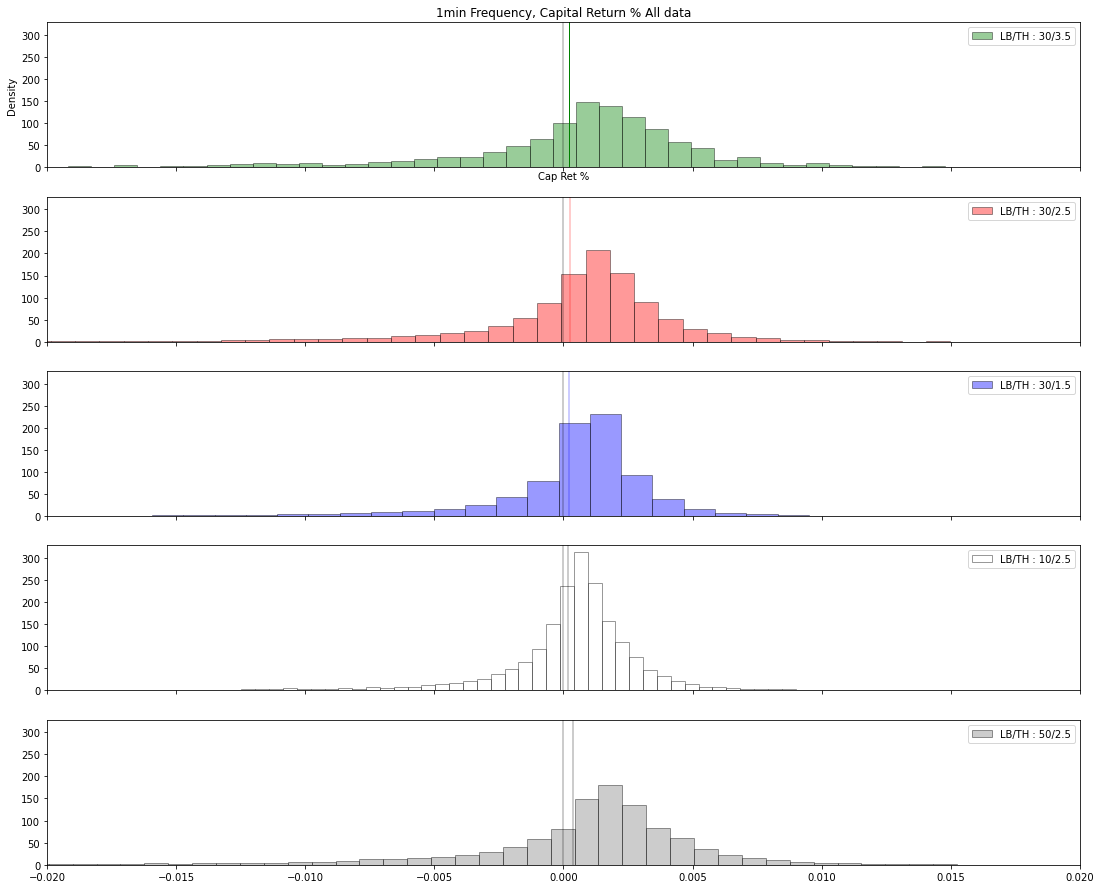

In [127]:
# Setup the bins and min/max of plot.
max_range = 0.02
min_range = -0.02

# setting up the axes
fig, axs = plt.subplots(5, 1, sharey='all', sharex='all')
fig.set_size_inches(18.5, 15.5)

# Create the plot
axs[0].set_title('1min Frequency, Capital Return % All data')
axs[0].set_ylabel('Density')
axs[0].set_xlabel('Cap Ret %')
axs[0].hist(dict_arrays['data_plot_3035.0'][~dict_arrays['data_plot_3035.0']['trade_return'].isna()][['trade_return']], 150, alpha = 0.4, density=True, color = "green", ec = 'black', lw = 1, label = 'LB/TH : 30/3.5')
axs[0].axvline(x=0, c='black', lw = 0.4)
axs[0].axvline(x=np.mean(dict_arrays['data_plot_3035.0'][~dict_arrays['data_plot_3035.0']['trade_return'].isna()]['trade_return']), c='green', lw = 1)
axs[1].hist(dict_arrays['data_plot_3025.0'][~dict_arrays['data_plot_3025.0']['trade_return'].isna()][['trade_return']], 150, alpha = 0.4, density=True, color = "red", ec = 'black', lw = 1, label = 'LB/TH : 30/2.5')
axs[1].axvline(x=0, c='black', lw = 0.4)
axs[1].axvline(x=np.mean(dict_arrays['data_plot_3025.0'][~dict_arrays['data_plot_3025.0']['trade_return'].isna()]['trade_return']), c='red', lw = 0.4)
axs[2].hist(dict_arrays['data_plot_3015.0'][~dict_arrays['data_plot_3015.0']['trade_return'].isna()][['trade_return']], 150, alpha = 0.4, density=True, color = "blue", ec = 'black', lw = 1, label = 'LB/TH : 30/1.5')
axs[2].axvline(x=0, c='black', lw = 0.4)
axs[2].axvline(x=np.mean(dict_arrays['data_plot_3015.0'][~dict_arrays['data_plot_3015.0']['trade_return'].isna()]['trade_return']), c='blue', lw = 0.4)
axs[3].hist(dict_arrays['data_plot_1025.0'][~dict_arrays['data_plot_1025.0']['trade_return'].isna()][['trade_return']], 150, alpha = 0.4, density=True, color = "white", ec = 'black', lw = 1, label = 'LB/TH : 10/2.5')
axs[3].axvline(x=0, c='black', lw = 0.4)
axs[3].axvline(x=np.mean(dict_arrays['data_plot_1025.0'][~dict_arrays['data_plot_1025.0']['trade_return'].isna()]['trade_return']), c='black', lw = 0.4)
axs[4].hist(dict_arrays['data_plot_5025.0'][~dict_arrays['data_plot_5025.0']['trade_return'].isna()][['trade_return']], 150, alpha = 0.4, density=True, color = "grey", ec = 'black', lw = 1, label = 'LB/TH : 50/2.5')
axs[4].axvline(x=0, c='black', lw = 0.4)
axs[4].axvline(x=np.mean(dict_arrays['data_plot_5025.0'][~dict_arrays['data_plot_5025.0']['trade_return'].isna()]['trade_return']), c='black', lw = 0.4)

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[2].legend(loc='upper right')
axs[3].legend(loc='upper right')
axs[4].legend(loc='upper right')
axs[0].set_xlim([min_range,max_range]) 

plt.show()

Analysis to look at wining trades, mean return and metrics for various thresholds / lookbacks

In [151]:
# Slow calculation
start = '2020-08-01'
end = '2022-08-01'

tc=0

# Create the class
mrbt = SingleVectorBT_MR(symbol,start,end,tc)

# collect the data
mrbt.get_data(path,type)

Mean_Results = np.empty(0)
Trades_Results = np.empty(0)
Winning_Results = np.empty(0)
DD_Results = np.empty(0)
Sharpe_Results = np.empty(0)
        
        
dict_Mean = {}
dict_Win = {}
dict_Trades = {}
dict_DD = {}
dict_Sharpe = {}

Thresh_Range = np.arange(start = 0.5, stop = 4.2, step = 0.1)

# run the strategy
for lookback in [30,50]:
    for Threshold in Thresh_Range:

        print('* Running strategy', lookback,':',Threshold)
        
        mrbt.run_strategy(lookback,Threshold)
        Output = mrbt.results.reset_index()
        Output = Output[~Output['trade_return'].isna()]['trade_return']
        
        Mean_Results = np.append(Mean_Results,np.mean(Output))
        Trades_Results = np.append(Trades_Results, len(Output))
        
        if len(Output) == 0:
            Winning =  0
        else:
            Winning = np.sum(Output>0)/len(Output)
        
        Winning_Results = np.append(Winning_Results,Winning)
        
        DD, Shar = mrbt.max_dd, mrbt.sharpe#calculate_perf(start, end, -999) # Note the threshold here is algo param (too slow)
        DD_Results = np.append(DD_Results, DD)
        Sharpe_Results = np.append(Sharpe_Results, Shar)
        
    Name='stress_plot_'+ str(lookback)
    dict_Mean[Name] = Mean_Results  
    dict_Win[Name] = Winning_Results 
    dict_Trades[Name] = Trades_Results 
    dict_DD[Name] = DD_Results 
    dict_Sharpe[Name] = Sharpe_Results

print('')    
Keep_Track()        

* Running strategy 30 : 0.5
Running strategy: lookback = 30,threshold = 0.5,tc = 0
raw return:1.0660960241389814,total return:369.96946105474404,sharpe:4.099706998875137,max_dd:-0.600871011521375
* Running strategy 30 : 0.6
Running strategy: lookback = 30,threshold = 0.6,tc = 0
raw return:1.0660960241389814,total return:324.48452848838605,sharpe:4.030089422859549,max_dd:-0.6020100697281493
* Running strategy 30 : 0.7
Running strategy: lookback = 30,threshold = 0.7,tc = 0
raw return:1.0660960241389814,total return:285.2844006083837,sharpe:4.009871385418963,max_dd:-0.5917922902450168
* Running strategy 30 : 0.7999999999999999
Running strategy: lookback = 30,threshold = 0.7999999999999999,tc = 0
raw return:1.0660960241389814,total return:219.59062726928244,sharpe:3.8740488832914473,max_dd:-0.5865152889716887
* Running strategy 30 : 0.8999999999999999
Running strategy: lookback = 30,threshold = 0.8999999999999999,tc = 0
raw return:1.0660960241389814,total return:215.91394218486752,sharpe:3

* Running strategy 50 : 0.5
Running strategy: lookback = 50,threshold = 0.5,tc = 0
raw return:1.0642585628870536,total return:67.39225777369458,sharpe:2.982829143241722,max_dd:-0.7713909285814973
* Running strategy 50 : 0.6
Running strategy: lookback = 50,threshold = 0.6,tc = 0
raw return:1.0642585628870536,total return:49.75283667969422,sharpe:2.8439735751412205,max_dd:-0.7898717191345046
* Running strategy 50 : 0.7
Running strategy: lookback = 50,threshold = 0.7,tc = 0
raw return:1.0642585628870536,total return:34.398920717957026,sharpe:2.631771413097803,max_dd:-0.7879732144803122
* Running strategy 50 : 0.7999999999999999
Running strategy: lookback = 50,threshold = 0.7999999999999999,tc = 0
raw return:1.0642585628870536,total return:31.604318022861342,sharpe:2.5943814866321064,max_dd:-0.759498305908305
* Running strategy 50 : 0.8999999999999999
Running strategy: lookback = 50,threshold = 0.8999999999999999,tc = 0
raw return:1.0642585628870536,total return:27.482671719019752,sharpe:2


Executed successfully. Thu 18 Aug @ 08:57:39



In [159]:
len(dict_Mean['stress_plot_50'][37:])

37

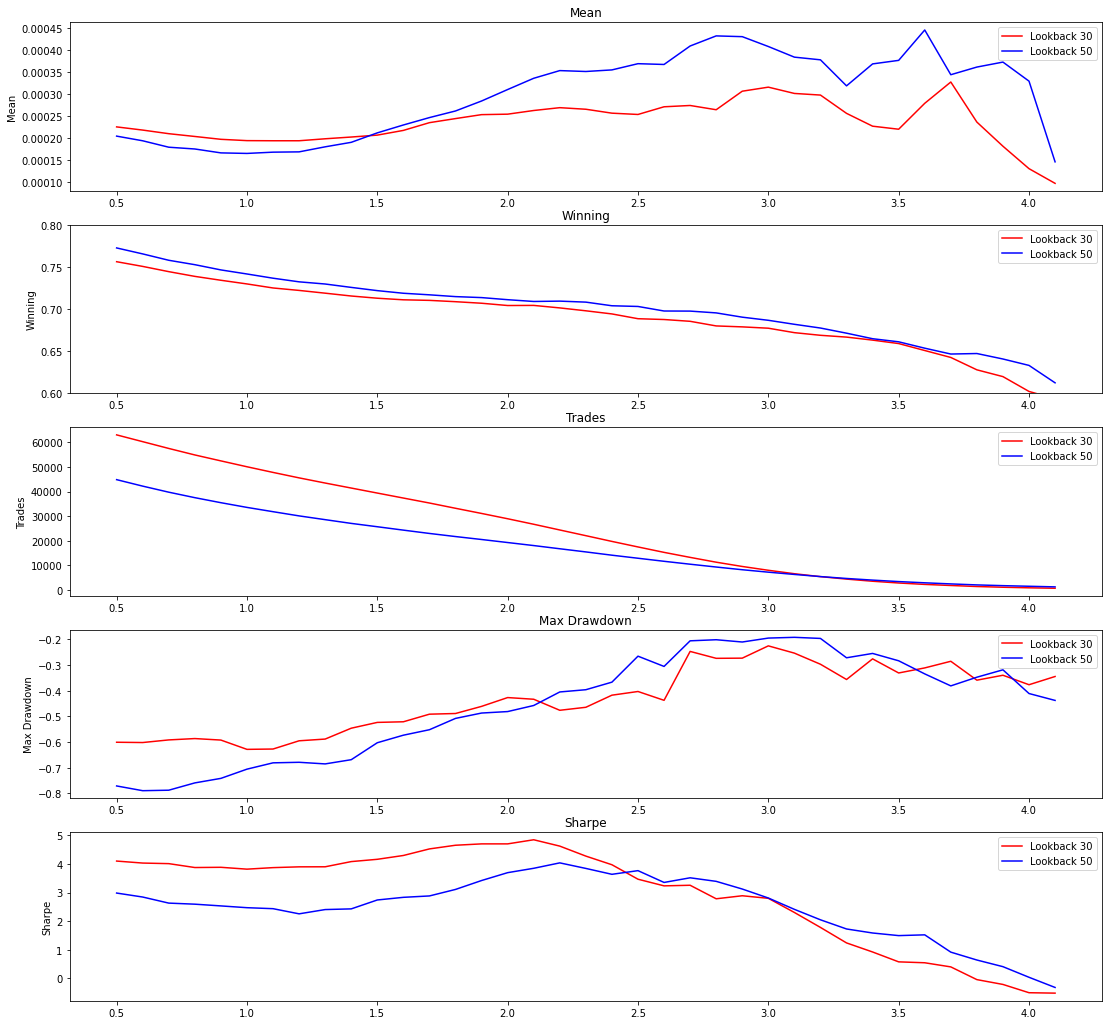

In [167]:
# Plot results
fig, axs = plt.subplots(5,1)
fig.set_size_inches(18.5, 18)

# Create the  plot
axs[0].plot(np.arange(start = 0.5, stop = 4.2, step = 0.1), dict_Mean['stress_plot_30'], color = 'r',label = 'Lookback 30')
axs[0].plot(np.arange(start = 0.5, stop = 4.2, step = 0.1), dict_Mean['stress_plot_50'][37:], color = 'b',label = 'Lookback 50')

axs[0].set_ylabel('Mean')
axs[0].set_title('Mean')
# axs[0].set_xlim([0,1])
# axs[0].set_ylim([-0.0006,0.0006])

axs[1].plot(np.arange(start = 0.5, stop = 4.2, step = 0.1), dict_Win['stress_plot_30'], color = 'r',label = 'Lookback 30')
axs[1].plot(np.arange(start = 0.5, stop = 4.2, step = 0.1), dict_Win['stress_plot_50'][37:], color = 'b',label = 'Lookback 50')

axs[1].set_ylabel('Winning')
axs[1].set_title('Winning')
axs[1].set_ylim([0.6,0.8])

axs[2].plot(np.arange(start = 0.5, stop = 4.2, step = 0.1), dict_Trades['stress_plot_30'], color = 'r',label = 'Lookback 30')
axs[2].plot(np.arange(start = 0.5, stop = 4.2, step = 0.1), dict_Trades['stress_plot_50'][37:], color = 'b',label = 'Lookback 50')

axs[2].set_ylabel('Trades')
axs[2].set_title('Trades')

axs[3].plot(np.arange(start = 0.5, stop = 4.2, step = 0.1), dict_DD['stress_plot_30'], color = 'r',label = 'Lookback 30')
axs[3].plot(np.arange(start = 0.5, stop = 4.2, step = 0.1), dict_DD['stress_plot_50'][37:], color = 'b',label = 'Lookback 50')

axs[3].set_ylabel('Max Drawdown')
axs[3].set_title('Max Drawdown')

axs[4].plot(np.arange(start = 0.5, stop = 4.2, step = 0.1), dict_Sharpe['stress_plot_30'], color = 'r',label = 'Lookback 30')
axs[4].plot(np.arange(start = 0.5, stop = 4.2, step = 0.1), dict_Sharpe['stress_plot_50'][37:], color = 'b',label = 'Lookback 50')

axs[4].set_ylabel('Sharpe')
axs[4].set_title('Sharpe')

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[2].legend(loc='upper right')
axs[3].legend(loc='upper right')
axs[4].legend(loc='upper right')